In [1]:
import random
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from make_dataset import get_data_for_days, calc_features

import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [2]:
BASE_SEED = 42

### Utils

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
seed_everything(BASE_SEED)

### Make dataset

In [53]:
training_end_date = "20241130"
# training_end_date = (datetime.now() - timedelta(days=1)).strftime("%Y%m%d")
training_days = 450

In [54]:
train_df = get_data_for_days(symbol="BTC_JPY", interval="1hour", end_date=training_end_date, days=training_days)

train_df.shape

(10703, 5)

In [55]:
train_df.tail()

,open,high,low,close,volume
openTime,,,,,
2024-12-01 01:00:00+09:00,14491985,14536859,14477942,14524126,12.68
2024-12-01 02:00:00+09:00,14526481,14540924,14512584,14514028,7.64
2024-12-01 03:00:00+09:00,14516267,14538573,14490564,14532082,12.4
2024-12-01 04:00:00+09:00,14534769,14540494,14515969,14534890,6.78
2024-12-01 05:00:00+09:00,14533874,14538677,14506066,14529347,5.18


In [57]:
# train_df.to_csv(os.path.join("data", "raw_data.csv"))
with open(os.path.join("data", "raw_data.pkl"), "wb") as f:
    pickle.dump(train_df, f)

In [6]:
train_df = calc_features(train_df, train=True)

train_df.shape

(10678, 21)

In [7]:
train_df.tail()

,return,high2low,high2mean,low2mean,high2median,low2median,return_mean_5,return_std_5,sharpe_5,return_mean_gap_5,return_mean_13,return_std_13,sharpe_13,return_mean_gap_13,return_mean_25,return_std_25,sharpe_25,return_mean_gap_25,target_return,target_return_sign,target_price_diff
openTime,,,,,,,,,,,,,,,,,,,,,
2024-12-01 00:00:00+09:00,0.002026,1.003980,1.002037,0.998065,1.002088,0.998115,0.001152,0.001508,0.763844,1.258293e+10,-0.000021,0.003026,-0.006920,-6.921964e+11,-0.000312,0.004282,-0.072841,-4.647657e+10,0.002215,1,32141.0
2024-12-01 01:00:00+09:00,0.002215,1.004069,1.002008,0.997947,1.001985,0.997924,0.001237,0.001564,0.790874,1.174049e+10,0.000148,0.003089,0.047972,9.799821e+10,-0.000545,0.003954,-0.137929,-2.663261e+10,-0.000858,0,-12453.0
2024-12-01 02:00:00+09:00,-0.000858,1.001953,1.001199,0.999248,1.001423,0.999472,0.000554,0.001588,0.348606,2.621196e+10,0.000050,0.003100,0.016270,2.877226e+11,-0.000690,0.003894,-0.177098,-2.104638e+10,0.001089,1,15815.0
2024-12-01 03:00:00+09:00,0.001089,1.003313,1.001322,0.998016,1.000991,0.997686,0.001017,0.001239,0.820569,1.429411e+10,-0.000160,0.002910,-0.054939,-9.089481e+10,-0.000634,0.003910,-0.162245,-2.290965e+10,0.000008,1,121.0
2024-12-01 04:00:00+09:00,0.000008,1.001690,1.000617,0.998929,1.000390,0.998702,0.000896,0.001315,0.681475,1.621688e+10,0.000206,0.002564,0.080239,7.064670e+10,-0.000080,0.002776,-0.028825,-1.816481e+11,-0.000312,0,-4527.0


In [60]:
# train_df.to_csv(os.path.join("data", "feature_data.csv"))
with open(os.path.join("data", "feature_data.pkl"), "wb") as f:
    pickle.dump(train_df, f)

### Train

In [8]:
target = "target_return_sign"
feature_cols = [f for f in train_df.columns if f not in ["target_return", "target_return_sign", "target_price_diff"]]

test_ratio = 0.2
purge_size = 75

lgb_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    # "max_depth": 11,
    # "num_leaves": 256,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 1.0,
    # "extra_trees": True,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "seed": BASE_SEED
}

In [9]:
def train_test_split(df, test_ratio=0.2, purge_size=0):
    total_size = len(df)
    test_size = int(total_size * test_ratio)
    train_size = total_size - test_size - purge_size

    return df.iloc[:train_size], df.iloc[train_size + purge_size:]

In [10]:
train, test = train_test_split(train_df, test_ratio=test_ratio, purge_size=purge_size)

train.shape, test.shape

((8468, 21), (2135, 21))

In [64]:
trn, val = train_test_split(train, test_ratio=test_ratio, purge_size=purge_size)

trn.shape, val.shape

((6668, 17), (1685, 17))

In [65]:
trn_X, val_X = trn[feature_cols], val[feature_cols]
trn_y, val_y = trn[target], val[target]

model = lgb.LGBMClassifier(**lgb_params)

model.fit(
            trn_X,
            trn_y,
            eval_set=[(val_X, val_y)],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
        )

[LightGBM] [Info] Number of positive: 3414, number of negative: 3254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 6668, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511998 -> initscore=0.048000
[LightGBM] [Info] Start training from score 0.048000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.69088
[100]	valid_0's binary_logloss: 0.691991
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.69088


LGBMClassifier(learning_rate=0.01, n_estimators=10000, objective='binary',
               reg_alpha=1, reg_lambda=1, seed=42, subsample=0.8,
               subsample_freq=1)

,feature,importance_mean,importance_std
0,return,0.007342,0.000287
8,sharpe_5,0.006738,0.000319
5,low2median,0.004313,0.000263
7,return_std_5,0.004262,0.000245
6,return_mean_5,0.003869,0.000183
9,return_mean_gap_5,0.003503,0.000081
11,return_std_75,0.002860,0.000120
4,high2median,0.002648,0.000128
3,low2mean,0.001949,0.000088
13,return_mean_gap_75,0.001712,0.000116


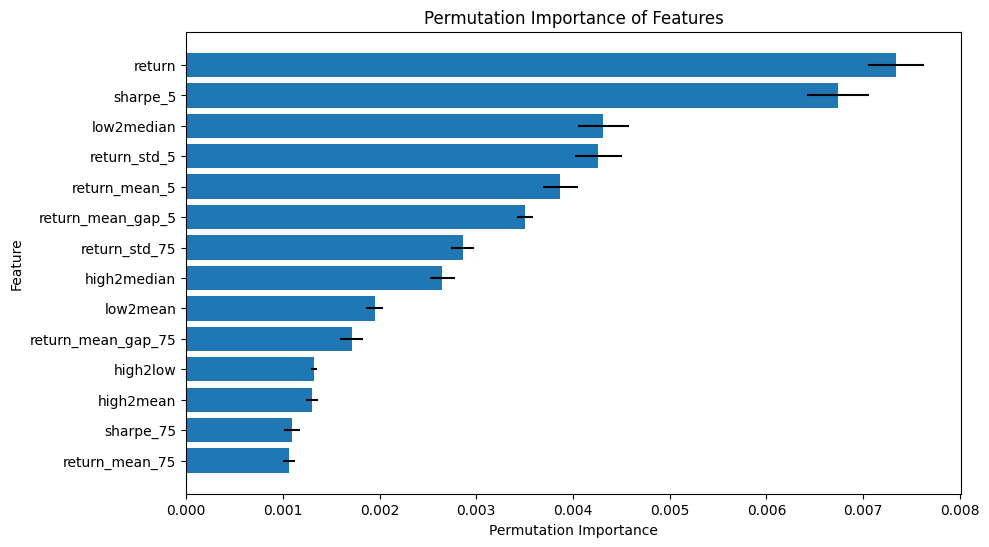

In [66]:
# # feature importance
# feature_importance = pd.DataFrame(model.booster_.feature_importance(importance_type="gain"), index=trn_X.columns, columns=["importance"])
# feature_importance = feature_importance.sort_values("importance", ascending=False)
# display(feature_importance)

# permutation importance
perm_importance = permutation_importance(model, trn_X, trn_y, scoring="neg_log_loss", n_repeats=10, random_state=BASE_SEED, n_jobs=-1)

perm_importance = pd.DataFrame({
    "feature": trn_X.columns.to_list(),
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std
}).sort_values(by="importance_mean", ascending=False)

display(perm_importance)

plt.figure(figsize=(10, 6))
plt.barh(perm_importance["feature"], perm_importance["importance_mean"], xerr=perm_importance["importance_std"])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Permutation Importance of Features")
plt.gca().invert_yaxis()
plt.show()

In [82]:
# richman non-stationarity score

from sklearn.metrics import r2_score

# LightGBMには組み込みの評価指標としてR²スコアが含まれていないため、カスタム評価指標を定義
def r2_metric(y_true, y_pred):
    return 'r2', r2_score(y_true, y_pred), True

lgb_params_adv = {
    "boosting_type": "gbdt",
    "objective": "regression",
    # "max_depth": 11,
    # "num_leaves": 256,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 1.0,
    # "extra_trees": True,
    "reg_alpha": 1,
    "reg_lambda": 1,
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "seed": BASE_SEED
}

model_adv = lgb.LGBMRegressor(**lgb_params_adv)

model_adv.fit(
            trn_X,
            np.arange(trn_X.shape[0]),
            eval_set=[(val_X, np.arange(val_X.shape[0]))],
            eval_metric=r2_metric,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
        )

feature_importance_adv = pd.DataFrame(model.booster_.feature_importance(importance_type="gain"), index=trn_X.columns, columns=["importance"])
feature_importance_adv = feature_importance_adv.sort_values("importance", ascending=False)
display(feature_importance_adv)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 6668, number of used features: 14
[LightGBM] [Info] Start training from score 3333.500000
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 8.56989e+06	valid_0's r2: -35.2207
Early stopping, best iteration is:
[1]	valid_0's l2: 6.49455e+06	valid_0's r2: -26.4493


,importance
sharpe_5,1510.694132
return,1376.340095
low2median,1246.085761
return_std_5,1093.506024
return_mean_gap_5,995.558003
return_std_75,923.821211
return_mean_5,840.335126
high2median,713.465487
return_mean_gap_75,630.635759
low2mean,596.914360


In [67]:
# モデルを保存
with open(os.path.join("models", "model.pkl"), "wb") as f:
    pickle.dump(model, f)

### Evaluate

In [68]:
def evaluate(model, test):
    result_df = test.copy()
    result_df["pred_proba"] = model.predict_proba(test[feature_cols])[:, 1]
    result_df["pred"] = result_df["pred_proba"].apply(lambda x: 1 if x >= 0.5 else 0)
    result_df["exe_decision"] = result_df["pred_proba"].apply(lambda x: 1 if x >= 0.5 else -1)
    # result_df["profit"] = result_df["exe_decision"] * result_df["target_return"]
    result_df["target_price_diff"] = result_df["target_price_diff"] * 0.01  # 注文サイズに合わせる
    result_df["profit"] = result_df["exe_decision"] * result_df["target_price_diff"]

    print("Profit during test period: ", int(result_df["profit"].sum()))
    print("Benchmark: ", int(result_df["target_price_diff"].sum()))

    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df["profit"].cumsum(), label="Model Strategy")
    plt.plot(result_df.index, result_df["target_price_diff"].cumsum(), label="Benchmark")
    plt.legend()
    plt.title("Cumulative Profit")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(result_df.index, result_df["profit"], label="Model Strategy")
    plt.legend()
    plt.title("Profit")
    plt.show()

    print("Accuracy: ", round(accuracy_score(result_df["target_return_sign"], result_df["pred"]), 4))
    print("Benchmark: ", round(result_df["target_return_sign"].mean(), 4))

    # 混同行列
    conf_matrix = confusion_matrix(result_df["target_return_sign"], result_df["pred"])

    fig, ax = plt.subplots(figsize=(8, 5))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.show()

    return result_df

Profit during test period:  27345
Benchmark:  57947


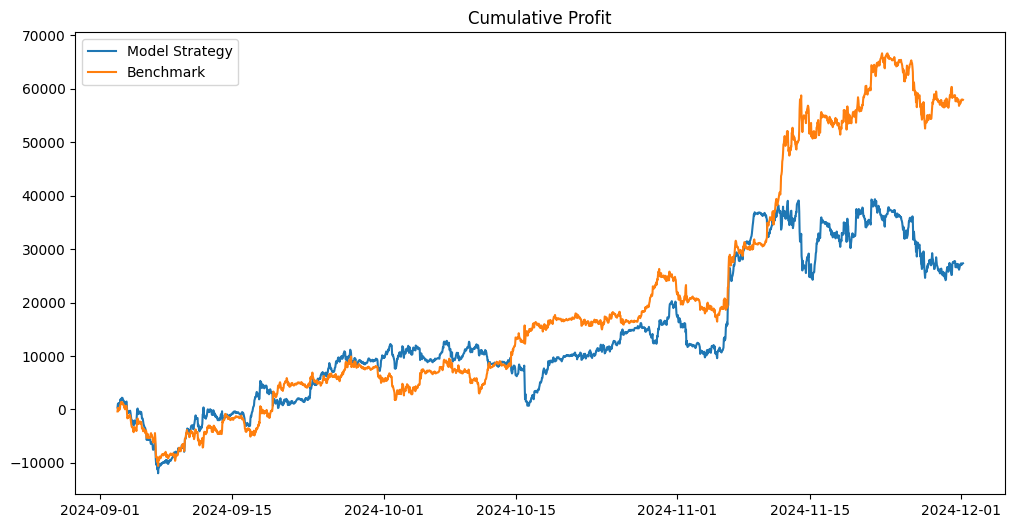

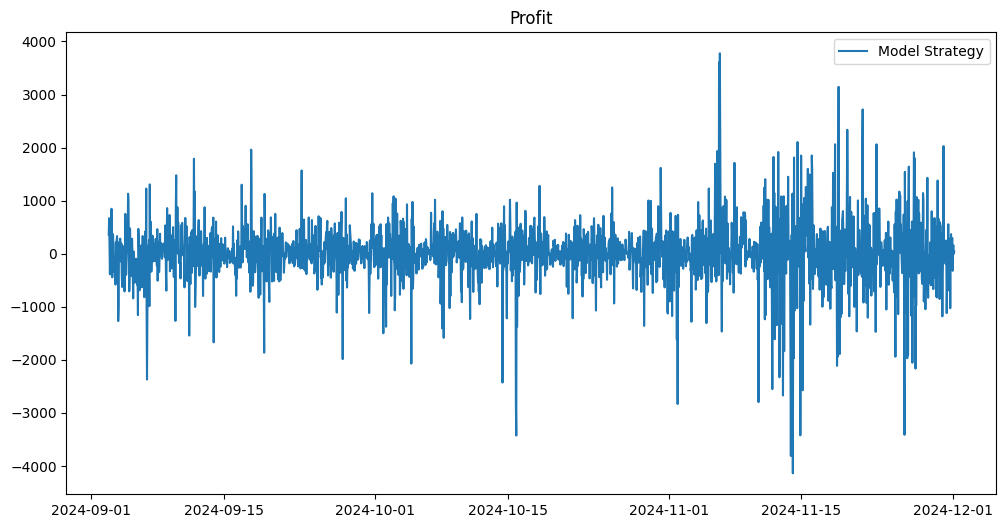

Accuracy:  0.5412
Benchmark:  0.5214


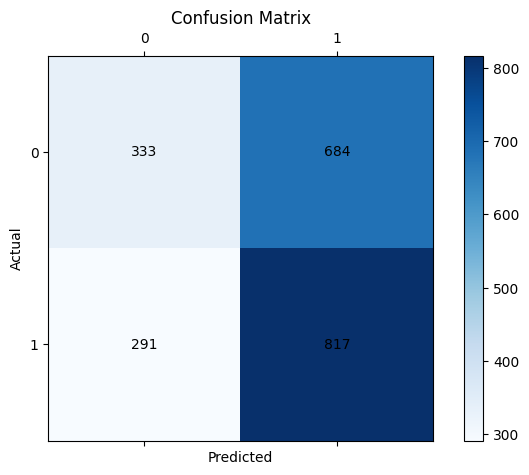

In [69]:
result_df = evaluate(model, test)